In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("cleaned_job_data.csv")

In [4]:
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [5]:
df.drop(columns=['Unnamed: 0'], inplace= True, errors='ignore')

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['job_title', 'salary_estimate', 'job_description', 'rating',
       'company_name', 'location', 'headquarters', 'size', 'founded',
       'type_of_ownership', 'industry', 'sector', 'revenue', 'competitors',
       'easy_apply'],
      dtype='object')

In [7]:
df.isnull().sum()

job_title            0
salary_estimate      0
job_description      0
rating               0
company_name         1
location             0
headquarters         0
size                 0
founded              0
type_of_ownership    0
industry             0
sector               0
revenue              0
competitors          0
easy_apply           0
dtype: int64

In [8]:
df = df.dropna(subset=['company_name'])

In [9]:
df.isnull().sum()

job_title            0
salary_estimate      0
job_description      0
rating               0
company_name         0
location             0
headquarters         0
size                 0
founded              0
type_of_ownership    0
industry             0
sector               0
revenue              0
competitors          0
easy_apply           0
dtype: int64

In [10]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_job_description'] = df['job_description'].apply(clean_text)

In [11]:
skill_dict = {
    "Programming": ['python', 'r', 'sql'],
    "BI_Tools": ['power bi', 'tableau', 'looker', 'Excel'],
    "Databases": ['mysql', 'postgresql', 'mongodb', 'oracle'],
    "Statistics": ['statistics', 'regression', 'hypothesis testing', 'a b testing'],
    "Big_Data": ['spark', 'hadoop'],
    "Soft_Skills": ['communication', 'stakeholder', 'presentation', 'collaboration']
}

In [12]:
def extract_skills(text, skills):
    found_skills = []
    for skill in skills:
        if re.search(r'\b' + re.escape(skill) + r'\b', text):
            found_skills.append(skill)
    return found_skills

for category, skills in skill_dict.items():
    df[category] = df['clean_job_description'].apply(lambda x: extract_skills(x, skills))

In [13]:
for category in skill_dict.keys():
    df[category] = df[category].apply(lambda x: 1 if len(x) > 0 else 0)

In [14]:
skill_demand = df[list(skill_dict.keys())].sum().sort_values(ascending=False)
skill_demand

Programming    1488
Soft_Skills    1249
BI_Tools        715
Statistics      604
Databases       311
Big_Data        159
dtype: int64

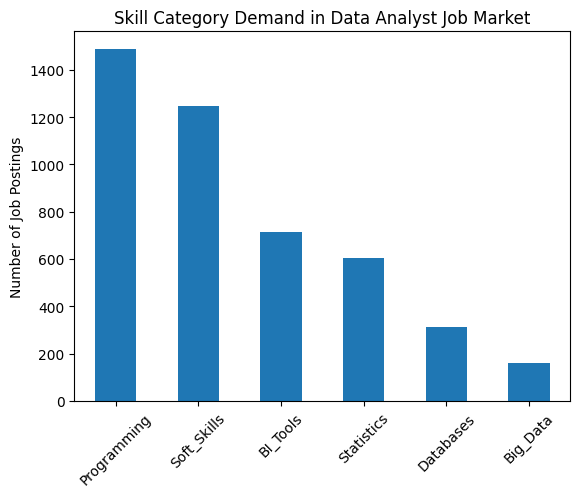

In [15]:
plt.figure()
skill_demand.plot(kind='bar')
plt.title("Skill Category Demand in Data Analyst Job Market")
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
plt.show()

In [16]:
df['experience_level'] = df['job_title'].str.lower().apply(
    lambda x: 'Senior' if any(word in x for word in ['senior', 'lead', 'principal']) else 'Entry'
)


In [18]:
df.to_csv("cleaned_job_data.csv", index=False)

In [19]:
experience_skill_gap = df.groupby('experience_level')[list(skill_dict.keys())].mean().round(2)
experience_skill_gap.to_csv("experience_skill_gap.csv")

In [20]:
df = df[df['salary_estimate'] != '-1']

In [21]:
df['salary_cleaned'] = (
df['salary_estimate']
.str.replace('K', '', regex=False)
.str.replace('$', '', regex=False)
.str.replace('(Glassdoor est.)', '', regex=False)
.str.replace('(Employer est.)', '', regex=False)
.str.strip()
)

In [22]:
df[['min_salary', 'max_salary']] = df['salary_cleaned'].str.split('-', expand=True)

In [23]:
df['min_salary'] = pd.to_numeric(df['min_salary'], errors='coerce')
df['max_salary'] = pd.to_numeric(df['max_salary'], errors='coerce')

In [24]:
df['avg_salary'] = (df['min_salary'] + df['max_salary']) / 2

In [25]:
df[['salary_cleaned', 'min_salary', 'max_salary', 'avg_salary']].head()

,salary_cleaned,min_salary,max_salary,avg_salary
0,37-66,37,66,51.5
1,37-66,37,66,51.5
2,37-66,37,66,51.5
3,37-66,37,66,51.5
4,37-66,37,66,51.5


In [26]:
df.to_csv("cleaned_job_data.csv", index=False)

In [27]:
avg_salary_by_experience = df.groupby('experience_level')['avg_salary'].mean().round(2)
avg_salary_by_experience.to_csv('avg_salary_by_experience.csv')

In [28]:
skill_summary = df[list(skill_dict.keys())].sum().reset_index()
skill_summary.columns = ['Skill_Category', 'Job_Count']

skill_summary.to_csv("skill_summary.csv", index=False)

In [29]:
df.head()

,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,founded,type_of_ownership,...,BI_Tools,Databases,Statistics,Big_Data,Soft_Skills,experience_level,salary_cleaned,min_salary,max_salary,avg_salary
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,...,0,0,1,0,1,Entry,37-66,37,66,51.5
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,...,0,0,1,0,1,Entry,37-66,37,66,51.5
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,...,1,0,0,0,1,Senior,37-66,37,66,51.5
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,...,1,0,0,0,1,Entry,37-66,37,66,51.5
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,...,0,0,0,0,0,Entry,37-66,37,66,51.5


In [30]:
df.columns

Index(['job_title', 'salary_estimate', 'job_description', 'rating',
       'company_name', 'location', 'headquarters', 'size', 'founded',
       'type_of_ownership', 'industry', 'sector', 'revenue', 'competitors',
       'easy_apply', 'clean_job_description', 'Programming', 'BI_Tools',
       'Databases', 'Statistics', 'Big_Data', 'Soft_Skills',
       'experience_level', 'salary_cleaned', 'min_salary', 'max_salary',
       'avg_salary'],
      dtype='object')